In [136]:
import time
import requests
import pprint
import pandas
import operator
import numpy
import math
from sklearn import linear_model

%matplotlib inline
import matplotlib
matplotlib.style.use('seaborn-muted')

# Facebook Graph API

As the world's most popular social networking site, Facebook's data, their **social graph**, is a treasure trove for data scientists. To enable developers to read and write Facebook's data, they offer the **Graph API**, which provides users with a view of the Facebook social graph, representing nodes in the graph (people, places, events, pages, etc.) and the connections between these nodes (friendships, follower relationships, attendee relationships, etc.).

In this tutorial, we present an overview of Facebook's Graph API, focusing on three aspects:

1. [Understanding the Graph API](#Understanding-the-Graph-API)
2. [Using the Graph API](#Using-the-Graph-API)
3. [Applying the Graph API](#Applying-the-Graph-API)

Since writing data isn't highly relevant in the data science context, we intentionally deemphasize these functions of the Graph API.

## Understanding the Graph API

As of this tutorial, the current and latest version of the Graph API is v2.7. We assume the reader is using this version of the API.

In [3]:
version = '2.7'

### Structure

Facebook's Graph API encapsulates their social graph. As expected, the social graph consists of nodes and edges that are assigned semantics as follows:

- **[nodes](https://developers.facebook.com/docs/graph-api/reference)**: things (e.g. users, photos, groups, events) with *fields* with information about these things (e.g. a user's birthday, a photo's location)
- **edges**: connections between these things (e.g. a user's friends, a comment's likes)

Each node of the social graph has its own unique id, we'll find this useful later in the tutorial.

### Security

Authentication to the Graph API is controlled using [access tokens](https://developers.facebook.com/docs/facebook-login/access-tokens), alphanumeric strings that identify an application and are used to make API calls. While there are multiple types of tokens and complex workflows involved with obtaining tokens, a discussion of these topics is outside of the scope for this tutorial. 

A detailed look at permissions, Facebook's method of ensuring data security and privacy is also out of scope. We simply note that an access token is associated with a particular set of permissions, e.g. the permission to access a user's likes or post to their wall.

Going forward, we will assume that the reader uses Facebook's [Graph API Explorer](https://developers.facebook.com/tools/explorer) (as mentioned below), to acquire a user access token with all necessary permissions after [creating a test application](https://developers.facebook.com/docs/apps/register). While an access token from the API Explorer application itself is often sufficient, creating a test application provides some extra permissions that we exploit later in the tutorial.

In [35]:
# Copy your access token below
access_token = '[REDACTED]'

### Requests

Facebook's Graph API is a [RESTful API](https://en.wikipedia.org/wiki/Representational_state_transfer), accessible through HTTP requests. As a RESTful API, the Graph API is stateless and operates with the standard HTTP verbs: GET, POST, PUT, DELETE and UPDATE. Most requests to the API will use the https://graph.facebook.com/ base URL and return JSON.

Since HTTP libraries are present in the majority of progrmmng languages, the Graph API is accessible with most languages. It can even be accessed directly through a browser or the command line with `curl` as highlighted below:

    $ curl -X GET "https://graph.facebook.com/v2.7/me?access_token=REDACTED"
    
    {"name":"Sushain Cherivirala","id":"10202983494531833"}

Facebook offers [official](https://developers.facebook.com/tools/explorer) SDKs that support the Graph API for iOS, Android, JavaScript, React and PHP as well as a web interface, the [Graph API Explorer](https://developers.facebook.com/tools/explorer). Unfortunately, their [listing](https://developers.facebook.com/docs/apis-and-sdks#third-party-sdks) of third-party SDKs doesn't include a Python option despite the presence of a community developed [Facebook Python SDK](https://github.com/mobolic/facebook-sdk), the library we will use throughout this tutorial.

## Using the Graph API

While we could use the `requests` library or Python's builtin HTTP libraries to call the Graph API, we opt to use the open source community SDK mentioned above for the sake of writing cleaner, more extensible code.

### Installation

Use the Python Package Index (pip),

     $ pip install facebook-sdk
     
### Getting Started

Let's start off by initializing our `graph` object and performing the same query as we did with curl above.

In [36]:
import facebook

graph = facebook.GraphAPI(access_token=access_token, version=version)
me = graph.get_object(id='me')

In [5]:
graph.get_object(id=me['id'], fields='birthday')

{u'birthday': u'04/12/1997', u'id': u'10207343827217425'}

Your output should look something like the following except with your own account:

    {u'id': u'10202983494531833', u'name': u'Sushain Cherivirala'}

Awesome! We've made our first query to Facebook's Graph API and successfully received a result. As you might have noticed, our output is a Python dictionary instead of JSON Here's one of the places that using a SDK helps us. By taking care of the JSON parsing details, the library helps us focus on the important stuff.

For example, we note that the `get_object` function fetches a **node** from the social graph with the specified id, returning its **fields**. We fetched from the special `/me` endpoint which defaults to the node corresponding to the access token's user. 

### Accessing Fields

We could have also accessed the same node by directly using its id:

In [6]:
graph.get_object(id='me', fields='gender')

{u'gender': u'male', u'id': u'10207343827217425'}

This time we've also elected to retrieve the `birthday` field. Since the `/me` endpoint corresponds to a user, we can check Facebook's [documentation](https://developers.facebook.com/docs/graph-api/reference/user/) for the `User` node to find a complete listing of a User node's fields. Accessing multiple fields is as simple as comma-separating them:

In [7]:
graph.get_object(id='me', fields='gender,birthday')

{u'birthday': u'04/12/1997', u'gender': u'male', u'id': u'10207343827217425'}

Fields aren't always flat strings, they can certainly be more interesting:

In [8]:
graph.get_object(id='me', fields='education')

{u'education': [{u'id': u'1814664649889',
   u'school': {u'id': u'103736699664777', u'name': u'Dulles High School'},
   u'type': u'High School',
   u'year': {u'id': u'105576766163075', u'name': u'2015'}},
  {u'concentration': [{u'id': u'104076956295773',
     u'name': u'Computer Science'}],
   u'id': u'10204211781558241',
   u'school': {u'id': u'7133766387', u'name': u'Carnegie Mellon University'},
   u'type': u'College',
   u'year': {u'id': u'224452140917757', u'name': u'2019'}}],
 u'id': u'10207343827217425'}

### Working with Edges

Let's try something a bit more exciting than reading static pieces of information. How about finding all the taggable<sup>1</sup> friends a user has, the canonical example of edges in the social graph?

<sup>1</sup> As of v2.0, the Graph API [no longer allows](http://stackoverflow.com/a/23417628/1266600) fetching all friends due to privacy concerns.

In [9]:
graph.get_connections(id='me', connection_name='taggable_friends')

{u'data': [{u'id': u'AaLz29Gdb7HfYh2f5cHSTJrW5qjntW21gsZLcmzPbcUllwLECQ6eveJ3zk_zsgwVv928cozZCz9u_7w2mhYaLuDyc8zZpFu7YWjr2Amf3vLtIg',
   u'name': u'Vijaya Koppnur',
   u'picture': {u'data': {u'is_silhouette': True,
     u'url': u'https://scontent.xx.fbcdn.net/v/t1.0-1/c15.0.50.50/p50x50/1379841_10150004552801901_469209496895221757_n.jpg?oh=ae33d49c23915f07a8d0a90acce21208&oe=588D7733'}}},
  {u'id': u'AaLX5kOmciUZczq5o0OZUya80s1XFdeIsKbPDg6LWHk3txpPt73OGl4OtE4m2Upn95QhWH8EMdcIdvr0v9uh5cOWDFTkWHwRtNB0E9kwKfZRwQ',
   u'name': u'Crystal Lee',
   u'picture': {u'data': {u'is_silhouette': False,
     u'url': u'https://scontent.xx.fbcdn.net/v/t1.0-1/p50x50/14332962_1244263395643606_4561898397943723058_n.jpg?oh=0b432ece2a9bc109058ae8f3178f7b01&oe=58D35E4B'}}},
  {u'id': u'AaJqRk8lzBZQMttuDEtjL8BRUl2lV8-iRfY6R_8zwOBNyg1N3YnNlXjMcBu54xzhGVjddJ8wu7GOd-IxlWOPCyJ9Xcg254MJC4ibeagcegYcWQ',
   u'name': u'Fang You',
   u'picture': {u'data': {u'is_silhouette': False,
     u'url': u'https://scontent.xx.fb

You might notice that something looks wrong (unless you have a very small number of friends). The API call only returns a handful of your friends, specifically 25 of them. We'll have to take advantage of the extra paging data we receive (at the end of the output) to fetch all our friends. We define a couple helper functions to retrieve all the data for both connections (edges) and objects (nodes):

In [86]:
def recurse(response, delay, fn, *args, **kwargs):
    '''iterate through all the pages of a response, either using the cursor or falling back to URLs'''
    data = []
    data.extend(response['data'])
        
    # the Graph API doesn't always return a cursor, sometimes only a next URL
    next_url = response['paging'].get('next', None)
    cursor = response['paging'].get('cursors', {'after': None})['after']

    if cursor:
        while cursor:
            kwargs['after'] = cursor
            response = fn(*args, **kwargs)
            data.extend(response['data'])
            cursor = response['paging']['cursors']['after'] if 'paging' in response else None
            time.sleep(delay)
    elif next_url:
        while next_url:
            response = requests.get(next_url).json()
            data.extend(response['data'])
            next_url = response['paging']['next'] if 'paging' in response else None
            time.sleep(delay)
    
    return data

def get_all_connections(graph, *args, **kwargs):
    '''get all the connections from a particular node in the social graph'''
    delay = kwargs.pop('delay', 3)
    response = graph.get_connections(*args, **kwargs) # get first page of data    
    return recurse(response, delay, graph.get_connections, *args, **kwargs)

def get_all_objects(graph, **kwargs):
    '''get the fields for a list of nodes in the social graph'''
    ids = kwargs.pop('ids')
    delay = kwargs.pop('delay', 3)

    # the Graph API only allows requesting 50 IDs at a time
    objects = {}
    for i in range(0, len(ids), 50):
        kwargs['ids'] = ids[i:i+50]
        response = graph.get_objects(**kwargs)
        for id, obj in response.items():
            # these are connections, we have to recurse to find them all
            if type(obj) == dict:
                for field, value in obj.items():
                    if type(value) == dict and 'data' in value:
                        obj[field] = recurse(value, delay, graph.get_connections, id=id, connection_name=field)
                response[id] = obj
        objects.update(response)
    return objects

In [14]:
taggable_friends = get_all_connections(graph, id='me', connection_name='taggable_friends')
print(len(taggable_friends))

1100


Here, we note that I have 1100 taggable friends, making up about 95% of my 1,141 total friends. Your mileage may vary with this API call. Moreover, since we aren't given access to the real node IDs of friends, the Graph API makes it impossible to build a graph of our friends by preventing us from fetching friends of friends. Reverse engineering Facebook's website would make this possible; however, a discussion of this falls out of scope for this tutorial (it likely also violates Facebook's TOS). Instead, we will focus on Facebook's other primary category of nodes, posts.

## Applying the Graph API

The Graph API affords us significantly greater latitude in fetching our own posts than with friend retrieval, enabling text processing and all other kinds of data science goodness. To start of, let's fetch all the posts on my [feed](https://developers.facebook.com/docs/graph-api/reference/v2.8/user/feed) by finding all the edges from me to posts. As the documentation notes, this API call fetches both posts the user is tagged in as well as the ones they published.

In [140]:
feed = get_all_connections(graph, id='me', connection_name='feed')
print(len(feed))
feed_df = pandas.DataFrame(feed)
feed_df['created_time'] = pandas.to_datetime(feed_df['created_time'])
feed_df.head()

408


,created_time,id,message,story
0,2016-10-31 11:16:21,10202983494531833_10207636886023712,I fondly recall and relish the happy memories...,Mallaiah Anchoori with Spoorthi Cherivirala an...
1,2016-10-24 23:09:44,10202983494531833_10207584723759688,Join us for Senate Week Fall 2016! \n\nWe will...,Sushain Cherivirala updated his cover photo.
2,2016-10-06 23:55:53,10202983494531833_10207437128629902,NaN,Sushain Cherivirala shared Carnegie Mellon Stu...
3,2016-10-06 22:07:15,10202983494531833_10207437060828207,NaN,Carnegie Mellon Student Senate added a new pho...
4,2016-09-24 00:08:29,10202983494531833_10207342298419206,NaN,Sushain Cherivirala shared Carnegie Mellon Stu...


While 408 posts appears to be reasonable number for me, let's quickly verify that we're fetching all the posts with a plot before aggregating more meta-information about the posts themselves.

(array([   2.,    0.,    1.,    0.,    0.,    0.,  124.,  178.,   35.,   68.]),
 array([ 729126.29166667,  729840.50946875,  730554.72727083,
         731268.94507292,  731983.162875  ,  732697.38067708,
         733411.59847917,  734125.81628125,  734840.03408333,
         735554.25188542,  736268.4696875 ]),
 <a list of 10 Patch objects>)

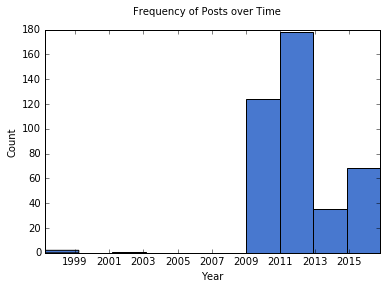

In [141]:
matplotlib.pyplot.xlabel('Year')
matplotlib.pyplot.ylabel('Count')
matplotlib.pyplot.suptitle('Frequency of Posts over Time')
matplotlib.pyplot.hist(list(feed_df['created_time']))

While the post appearing as created in 1997 may appear strange to the reader since it occurs before the inception of Facebook, this post marks a life event (my birth). Moving forward, we gather more information about each post,

In [145]:
post_ids = map(operator.itemgetter('id'), feed)
post_info = get_all_objects(graph, ids=post_ids, fields='type,reactions,message_tags')
pprint.pprint(list(post_info.items())[42])

(u'10202983494531833_2496114285704',
 {u'id': u'10202983494531833_2496114285704',
  u'message_tags': [{u'id': u'10204004208928150',
                     u'length': 15,
                     u'name': u'Keerthana Kumar',
                     u'offset': 0,
                     u'type': u'user'},
                    {u'id': u'10205292610620759',
                     u'length': 14,
                     u'name': u'Michelle Huang',
                     u'offset': 32,
                     u'type': u'user'},
                    {u'id': u'786746358022897',
                     u'length': 15,
                     u'name': u'Anjali Chikkula',
                     u'offset': 47,
                     u'type': u'user'},
                    {u'id': u'10204572063374660',
                     u'length': 12,
                     u'name': u'Maxine Huang',
                     u'offset': 63,
                     u'type': u'user'},
                    {u'id': u'841533145894026',
                     u'length

Given all this information, we can build a model for the number of [reactions](https://developers.facebook.com/docs/graph-api/reference/post/reactions) to a Facebook post based on the metadata of the post. Let's build up a dataframe with features to solve this problem as well as the target values.

(array([ 369.,   15.,    5.,    3.,    3.,    3.,    2.,    2.,    0.,    2.]),
 array([   0. ,   12.6,   25.2,   37.8,   50.4,   63. ,   75.6,   88.2,
         100.8,  113.4,  126. ]),
 <a list of 10 Patch objects>)

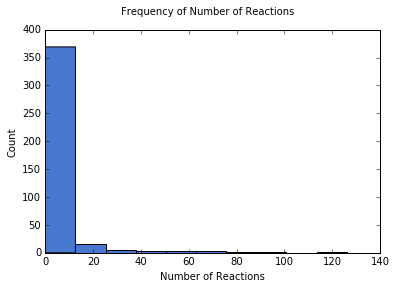

In [168]:
# build up a dataframe of target values (number of reactions)
reactions = pandas.DataFrame(map(
    lambda x: {'id': x[0], 'num_reactions': len(x[1].get('reactions', []))}, 
    post_info.items()
))

# plot it
matplotlib.pyplot.xlabel('Number of Reactions')
matplotlib.pyplot.ylabel('Count')
matplotlib.pyplot.suptitle('Frequency of Number of Reactions')
matplotlib.pyplot.hist(reactions['num_reactions'])

We note that the distribution is very skew and since the dataset is relatively small, we might not be able to build an excellent model. However, our model only serves as a proof of concept. More data could be gathered using the Graph API to better the model's parameters. We could also make use of the content of the posts itself by building a TFIDF vector.

In [187]:
# add number of reactions to our dataframe
feed_features_df = feed_df.merge(reactions, on='id')

# add the post types to our dataframe
type_df = pandas.DataFrame(map(lambda x: {'id': x[0], 'type': x[1]['type']}, post_info.items()))
feed_features_df = feed_features_df.merge(type_df, on='id')
type_dummies = pandas.get_dummies(feed_features_df['type'], prefix='type')
feed_features_df = pandas.concat([feed_features_df, type_dummies], axis=1)

# add the number of tags
num_tags = dict(map(lambda x: (x['id'], len(x.get('message_tags', []))), post_info.values()))
feed_features_df = feed_features_df.assign(num_tags=feed_df['id'].map(lambda x: num_tags.get(x, 0)))

# add some extra time features
feed_features_df = feed_features_df.assign(year=feed_df['created_time'].map(lambda x: x.year))
feed_features_df = feed_features_df.assign(month=feed_df['created_time'].map(lambda x: x.month))

hour_sin_feature = feed_df['created_time'].map(lambda x: math.sin(2 * math.pi * x.hour / 24.0))
feed_features_df = feed_features_df.assign(hour_sin=hour_sin_feature)
cos_sin_feature = feed_df['created_time'].map(lambda x: math.cos(2 * math.pi * x.hour / 24.0))
feed_features_df = feed_features_df.assign(hour_cos=cos_sin_feature)

# add a rough message length feature
message_lengths = feed_df['message'].map(lambda x: len(x.split()) if type(x) == unicode else 0)
feed_features_df = feed_features_df.assign(message_length=message_lengths)

# pull out our target (y) values
num_reactions_df = feed_features_df['num_reactions']

# drop extraneous columns that would not add value as features
feed_features_df = feed_features_df.drop(['id', 'message', 'story', 'created_time', 'type', 'num_reactions'], axis=1)

feed_features_df.head()

,type_event,type_link,type_photo,type_status,type_video,num_tags,year,month,hour_sin,hour_cos,message_length
0,0.0,1.0,0.0,0.0,0.0,0,2016,10,0.258819,-0.965926,34
1,0.0,0.0,1.0,0.0,0.0,2,2016,10,-0.258819,0.965926,47
2,0.0,0.0,1.0,0.0,0.0,0,2016,10,-0.258819,0.965926,0
3,0.0,0.0,1.0,0.0,0.0,0,2016,10,-0.500000,0.866025,0
4,1.0,0.0,0.0,0.0,0.0,0,2016,9,0.000000,1.000000,0


Now we can attempt to run a linear regression on these features as a proof of concept, choosing a random permutation of them as a holdout set to validate our model on.

In [195]:
# pick a permutation
numpy.random.seed(0)
holdout_set_indices = numpy.random.choice(range(len(feed_features_df)), len(feed_features_df) / 4)

# extract holdout and training features
holdout_feed_features_df = feed_features_df.loc[holdout_set_indices]
train_feed_features_df = feed_features_df.drop(holdout_set_indices)

# extract holdout and training targets
holdout_num_reactions = num_reactions_df.loc[holdout_set_indices]
train_num_reactions_df = num_reactions.drop(holdout_set_indices)

# run regression and score on the holdout validation set
lr = sklearn.linear_model.LinearRegression(normalize=True)
lr.fit(train_feed_features_df, train_num_reactions_df)
lr.score(holdout_feed_features_df, holdout_num_reactions)

0.19804856169659768

While we don't achieve an excellent score (R^2 coefficient of determination) for these features, the relatively small nature of the dataset and our limited set of features makes this unsurprising. We could also build different models for different post types, adding features such as video length for video posts and picture quality for photos to potentially reduce the error.

However, this does serve as a proof of concept of how to use Facebook's Graph API to retrieve data, process data and apply data science methods to it. There are many possible applications of the Graph API that we don't explore but offer to read as potential pursuits. Given a sufficiently large dataset, these are all interesting research propositions:

* Determining the most prominent reaction to a particular post (`NONE`, `LIKE`, `LOVE`, `WOW`, `HAHA`, `SAD`, `ANGRY`, or `THANKFUL`) given the comments on the post as well as the content of the post (a multiclass classification problem).
* Distinguishing clusters of friends and identifying what is the common uniting characteristic among them, e.g. all of the individuals attended a summer camp together or all the individuals worked at a particular place.
* Identifying the best time of day/week to make posts under the assumption that the primary goal is to accumulate as many reactions as possible.